<a href="https://colab.research.google.com/github/elenakelly/Information-Retrieval-and-Text-Mining/blob/main/02_3_Tutorial_query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining 2023
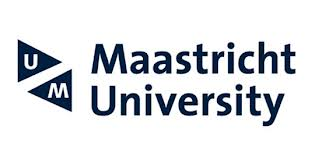
## Tutorial 2 - Notebook 3
Adapted and updated from [here](https://github.com/castorini/anserini-notebooks-afirm2020)

# Querying

In this exercise, we are going to first interactively query the index and then produce a TREC run with [Pyserini](https://github.com/castorini/pyserini), the Python interface to Anserini.

## Setup

Install Python dependencies (again - remember that each notebook instantiates a virtual machine of its own):

In [1]:
!pip install pyjnius==1.2.1
!pip install pyserini==0.9.2

import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyjnius: filename=pyjnius-1.2.1-cp39-cp39-linux_x86_64.whl size=1300288 sha256=cde228af99a059f0652dd66ff2bbe16e623b7f1a4d8fa7a0410e216384029937
  Stored in directory: /root/.cache/pip/wheels/65/67/95/c5585c9590117ba64bab542b65735d62f555b5cf137d604e1d
Successfully built pyjnius
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 7.2 MB/s eta 0:00:00


Fix known issue with pyjnius (see [this explanation](https://github.com/castorini/pyserini/blob/master/README.md#known-issues) for details):

In [2]:
!mkdir -p /usr/lib/jvm/java-1.11.0-openjdk-amd64/jre/lib/amd64/server/
!ln -s /usr/lib/jvm/java-1.11.0-openjdk-amd64/lib/server/libjvm.so /usr/lib/jvm/java-1.11.0-openjdk-amd64/jre/lib/amd64/server/libjvm.so

Instead of building anserini from scratch, we download the fatjar from the maven repository and store it locally:

In [3]:
!wget -O anserini-0.9.2-fatjar.jar https://search.maven.org/remotecontent?filepath=io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar

--2023-04-21 13:16:09--  https://search.maven.org/remotecontent?filepath=io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar
Resolving search.maven.org (search.maven.org)... 54.226.67.179, 3.227.154.178
Connecting to search.maven.org (search.maven.org)|54.226.67.179|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://repo1.maven.org/maven2/io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar [following]
--2023-04-21 13:16:09--  https://repo1.maven.org/maven2/io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62703127 (60M) [application/java-archive]
Saving to: ‘anserini-0.9.2-fatjar.jar’

anserini-0.9.2-fatj 100%[===================>]  59.80M   258MB/s    in 0.2s    

2023-04-21 13:16:10 (258 MB/s) 

Let's point Pyserini to the Anserini jar that we have just installed:

In [4]:
os.environ['ANSERINI_CLASSPATH'] = '.'

## Interactive Querying

We will need the index for the querying experments in this exercise.
Because Colab notebooks don't share data among themselves, i.e., each session runs on its own, we need to copy the data from the previous notebook. If you followed the steps from last notebook closely, you have already done so and the indexes are on your drive. Lets import them. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp -r /content/drive/MyDrive/IRTM/indexes/ /content/indexes/

In [7]:
from pyserini.search import pysearch
import itertools

Let's also grab MS Marco again and import the queries:

In [8]:
!mkdir -p data
!wget https://msmarco.blob.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
!tar -xvf collectionandqueries.tar.gz -C data

--2023-04-21 13:17:29--  https://msmarco.blob.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
Resolving msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)... 20.150.34.4
Connecting to msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)|20.150.34.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1057717952 (1009M) [application/gzip]
Saving to: ‘collectionandqueries.tar.gz’

collectionandquerie 100%[===================>]   1009M  22.2MB/s    in 32s     

2023-04-21 13:18:02 (31.0 MB/s) - ‘collectionandqueries.tar.gz’ saved [1057717952/1057717952]

collection.tsv
qrels.dev.small.tsv
qrels.train.tsv
queries.dev.small.tsv
queries.dev.tsv
queries.eval.small.tsv
queries.eval.tsv
queries.train.tsv


The hits data structure holds the docid, the retrieval score, as well as the document content.
Let's look at the top 10 passages for the query `south african football teams`:

In [9]:
from IPython.core.display import display, HTML

searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
interactive_hits = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits[i].docid, interactive_hits[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

Rank: 1 | Passage ID: 2225931 | BM25 Score: 11.718600273132324


Rank: 2 | Passage ID: 4959087 | BM25 Score: 11.63599967956543


Rank: 3 | Passage ID: 2646484 | BM25 Score: 11.590800285339355


Rank: 4 | Passage ID: 2646489 | BM25 Score: 11.526900291442871


Rank: 5 | Passage ID: 474761 | BM25 Score: 11.50059986114502


Rank: 6 | Passage ID: 4834928 | BM25 Score: 11.328499794006348


Rank: 7 | Passage ID: 7619756 | BM25 Score: 11.165300369262695


Rank: 8 | Passage ID: 830813 | BM25 Score: 11.10509967803955


Rank: 9 | Passage ID: 5660817 | BM25 Score: 11.051400184631348


Rank: 10 | Passage ID: 830809 | BM25 Score: 11.051399230957031


The above example uses default parameters.
Let's try setting tuned parameters for this collection:

In [10]:
searcher.set_bm25_similarity(0.82, 0.68)
interactive_hits_tuned = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned[i].docid, interactive_hits_tuned[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

Rank: 1 | Passage ID: 474761 | BM25 Score: 11.889699935913086


Rank: 2 | Passage ID: 4834928 | BM25 Score: 11.848899841308594


Rank: 3 | Passage ID: 2646484 | BM25 Score: 11.805800437927246


Rank: 4 | Passage ID: 830813 | BM25 Score: 11.76449966430664


Rank: 5 | Passage ID: 2646489 | BM25 Score: 11.703499794006348


Rank: 6 | Passage ID: 5660817 | BM25 Score: 11.671299934387207


Rank: 7 | Passage ID: 830809 | BM25 Score: 11.67129898071289


Rank: 8 | Passage ID: 2225931 | BM25 Score: 11.636099815368652


Rank: 9 | Passage ID: 7619756 | BM25 Score: 11.509300231933594


Rank: 10 | Passage ID: 4959087 | BM25 Score: 11.47029972076416


###Exercise #1
Compare the rankings with and without tuned parameters.
Add a new cell to query the index with a different query of your choice, both with untuned and tuned parameters.

In [12]:
# Search the index with untuned parameters
interactive_hits = searcher.search('climate change')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits[i].docid, interactive_hits[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))


Rank: 1 | Passage ID: 1725666 | BM25 Score: 7.764800071716309


Rank: 2 | Passage ID: 7544335 | BM25 Score: 7.75439977645874


Rank: 3 | Passage ID: 4118566 | BM25 Score: 7.752500057220459


Rank: 4 | Passage ID: 1254417 | BM25 Score: 7.746300220489502


Rank: 5 | Passage ID: 4677108 | BM25 Score: 7.693399906158447


Rank: 6 | Passage ID: 174747 | BM25 Score: 7.6774001121521


Rank: 7 | Passage ID: 8183638 | BM25 Score: 7.65500020980835


Rank: 8 | Passage ID: 2106825 | BM25 Score: 7.638500213623047


Rank: 9 | Passage ID: 4324750 | BM25 Score: 7.613399982452393


Rank: 10 | Passage ID: 7146964 | BM25 Score: 7.600500106811523


In [13]:
# Search the index with tuned parameters
searcher.set_bm25_similarity(0.82, 0.68)
interactive_hits_tuned = searcher.search('climate change')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned[i].docid, interactive_hits_tuned[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))


Rank: 1 | Passage ID: 1725666 | BM25 Score: 7.764800071716309


Rank: 2 | Passage ID: 7544335 | BM25 Score: 7.75439977645874


Rank: 3 | Passage ID: 4118566 | BM25 Score: 7.752500057220459


Rank: 4 | Passage ID: 1254417 | BM25 Score: 7.746300220489502


Rank: 5 | Passage ID: 4677108 | BM25 Score: 7.693399906158447


Rank: 6 | Passage ID: 174747 | BM25 Score: 7.6774001121521


Rank: 7 | Passage ID: 8183638 | BM25 Score: 7.65500020980835


Rank: 8 | Passage ID: 2106825 | BM25 Score: 7.638500213623047


Rank: 9 | Passage ID: 4324750 | BM25 Score: 7.613399982452393


Rank: 10 | Passage ID: 7146964 | BM25 Score: 7.600500106811523


Note how the ranking has changed.
We can also enable RM3 query expansion to see if it helps with our collection:

In [14]:
searcher.set_rm3_reranker(10, 10, 0.5)
interactive_hits_tuned_rm3 = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned_rm3[i].docid, interactive_hits_tuned_rm3[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits_tuned_rm3[i].raw + '</div>'))

Rank: 1 | Passage ID: 830813 | BM25 Score: 2.879300117492676


Rank: 2 | Passage ID: 830809 | BM25 Score: 2.857800006866455


Rank: 3 | Passage ID: 2646484 | BM25 Score: 2.726300001144409


Rank: 4 | Passage ID: 2646489 | BM25 Score: 2.7032999992370605


Rank: 5 | Passage ID: 4959087 | BM25 Score: 2.6442999839782715


Rank: 6 | Passage ID: 8831689 | BM25 Score: 2.6310999393463135


Rank: 7 | Passage ID: 4528472 | BM25 Score: 2.6001999378204346


Rank: 8 | Passage ID: 7619756 | BM25 Score: 2.5982000827789307


Rank: 9 | Passage ID: 3812886 | BM25 Score: 2.5480000972747803


Rank: 10 | Passage ID: 1554969 | BM25 Score: 2.5302000045776367


## Batch Retrieval

Previously we interactively queried the index.
However, in a typical experimental setting, you would evaluate over a larger number of queries to test different information needs.

Let's begin by constructing the dev queries and corresponding query IDs:

In [15]:
topics = {}
with open('data/queries.dev.small.tsv') as file:
    for line in file:
       id, q = line.strip().split('\t')
       topics[int(id)] = q

print('{} queries total'.format(len(topics)))

6980 queries total


In [16]:
queries = list(topics.values())
qids = list([str(t) for t in topics.keys()])

### Exercise #2
We have previously looked at these queries in the last activity.
Again find the queries that contain `football`.

In [17]:
for id, q in topics.items():
    if 'football' in q:
        print(f'Query {id}: {q}')

Query 1085780: what conference is bryant for football
Query 570979: what are the leagues of football in rockford il
Query 39908: average pay for nfl football players
Query 1038685: who is statesboro new football coach


Now, let's run all the queries from the dev set.
For the sake of speed, let's again only retrieve the top 5 documents for each query.
Note that this step may still take a while.

In [18]:
searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
bm25_hits = searcher.batch_search(queries, qids, k=5)

Note that the above runs batch retrieval with untuned BM25.
We can repeat with tuned parameters, just like we did for the interactive queries:

In [19]:
searcher.set_bm25_similarity(0.82, 0.68)
bm25_hits_tuned = searcher.batch_search(queries, qids, k=5)

Now let's repeat with RM3 query expansion (May take a while):

In [20]:
searcher.set_rm3_reranker(10, 10, 0.5)
bm25_hits_tuned_rm3 = searcher.batch_search(queries, qids, k=5)

### Exercise #3
Produce a run for untuned BM25 with RM3.

In [23]:
searcher.set_bm25_similarity(0.82, 0.68)
searcher.set_rm3_reranker(10, 10, 0.5)
bm25_hits_tuned_rm3 = searcher.batch_search(queries, qids, k=5)

### Exercise #4
So far we have downloaded and retrieved the top passages for the dev queries.
Now use the eval queries (data/queries.eval.small.tsv) and repeat the process for eval queries.

In [24]:
topics = {}
with open('data/queries.eval.small.tsv') as file:
    for line in file:
       id, q = line.strip().split('\t')
       topics[int(id)] = q

print('{} queries total'.format(len(topics)))
queries = list(topics.values())
qids = list([str(t) for t in topics.keys()])


6837 queries total


In [25]:
searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
bm25_hits = searcher.batch_search(queries, qids, k=5)
searcher.set_bm25_similarity(0.82, 0.68)
bm25_hits_tuned = searcher.batch_search(queries, qids, k=5)
searcher.set_rm3_reranker(10, 10, 0.5)
bm25_hits_rm3 = searcher.batch_search(queries, qids, k=5)

In [ ]:
from pyserini.output_writer import OutputWriter

output_path = 'bm25_rm3_run.txt'
with OutputWriter(output_path) as writer:
    for qid, query in topics.items():
        for i, doc in enumerate(bm25_hits_tuned[qid]):
            writer.write(qid, doc.docid, i+1, doc.score, 'bm25_tuned')
        for i, doc in enumerate(bm25_hits_rm3[qid]):
            writer.write(qid, doc.docid, i+1, doc.score, 'bm25_rm3')
        for i, doc in enumerate(bm25_hits[qid]):
            writer.write(qid, doc.docid, i+1, doc.score, 'bm25')

## Evaluation

A crucial component of information retrieval research is evaluation and metrics.
The most common tool used to achieve this goal is `trec_eval` developed by [NIST](https://www.nist.gov/).

`trec_eval` defines a number of standard retrieval measures, the details of which can be seen [here](http://www.rafaelglater.com/en/post/learn-how-to-use-trec_eval-to-evaluate-your-information-retrieval-system).

### TREC Format

`trec_eval` requires the runs from various experiments to be expressed in a standard TREC format:

`query_id iter docno rank similarity run_id` delimited by spaces

- `query_id`: query ID
- `iter`: constant, often either 0 or Q0 - required but ignored by `trec_eval`
- `docno`: string values that uniquely identify a document in the collection
- `rank`: integer, often zero indexed
- `similarity`: float value that represents the similarity of the document to the query specified by `query_id`
- `run_id`: string that identifies runs, used to keep track of different experiments - also ignored by `trec_eval`

Evaluation also requires the ground truth in the form of relevance judgements in the qrels file.
The qrels file follows the following format:

`query_id iter docno label`

- `label`: binary code (0 for not relevant and 1 for relevant)

Convert the hits for both BM25 (tuned and untuned) and BM25+RM3 runs into the TREC format:

In [26]:
def convert_to_trec_run(experiment, run_dict):
  with open('run.{}.txt'.format(experiment), 'w') as run_file:
    for qid in run_dict:
      for rank, doc in enumerate(run_dict[qid]):
        run_file.write('{} Q0 {} {} {} {}\n'.format(qid, doc.docid, rank, doc.score, experiment))

In [27]:
convert_to_trec_run('msmarco_passage_dev_bm25', bm25_hits)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned', bm25_hits_tuned)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned_rm3', bm25_hits_tuned_rm3)

Let's pull `trec_eval` again:

In [28]:
!git clone https://github.com/castorini/anserini-tools
!cd anserini-tools/eval && tar xvfz trec_eval.9.0.4.tar.gz && cd trec_eval.9.0.4 && make

Cloning into 'anserini-tools'...
remote: Enumerating objects: 788, done.
remote: Counting objects: 100% (545/545), done.
remote: Compressing objects: 100% (467/467), done.
remote: Total 788 (delta 101), reused 514 (delta 77), pack-reused 243
Receiving objects: 100% (788/788), 119.60 MiB | 20.66 MiB/s, done.
Resolving deltas: 100% (185/185), done.
Updating files: 100% (586/586), done.
trec_eval.9.0.4/
trec_eval.9.0.4/m_prefs_pair.c
trec_eval.9.0.4/m_ndcg_p.c
trec_eval.9.0.4/m_infap.c
trec_eval.9.0.4/m_num_q.c
trec_eval.9.0.4/m_iprec_at_recall.c
trec_eval.9.0.4/form_prefs_counts.c
trec_eval.9.0.4/m_prefs_num_prefs_ful_ret.c
trec_eval.9.0.4/utility_pool.c
trec_eval.9.0.4/m_binG.c
trec_eval.9.0.4/meas_avg.c
trec_eval.9.0.4/m_gm_bpref.c
trec_eval.9.0.4/m_runid.c
trec_eval.9.0.4/m_bpref.c
trec_eval.9.0.4/m_gm_map.c
trec_eval.9.0.4/trec_eval.h
trec_eval.9.0.4/m_yaap.c
trec_eval.9.0.4/m_relstring.c
trec_eval.9.0.4/m_Rprec.c
trec_eval.9.0.4/m_prefs_avgjg.c
trec_eval.9.0.4/m_success.c
trec_eval.

In [29]:
!mv anserini-tools/eval/trec_eval.9.0.4 ./



---



Now that we have our runs in the TREC format, we can evaluate them with `trec_eval`.


In [30]:
!head -5 run.msmarco_passage_dev_bm25.txt

901007 Q0 4446100 0 17.485200881958008 msmarco_passage_dev_bm25
901007 Q0 3570493 1 16.313400268554688 msmarco_passage_dev_bm25
901007 Q0 5268062 2 15.82390022277832 msmarco_passage_dev_bm25
901007 Q0 3989753 3 15.741399765014648 msmarco_passage_dev_bm25
901007 Q0 1719770 4 15.68179988861084 msmarco_passage_dev_bm25


In [31]:
!chmod -R +x trec_eval.9.0.4/

In [32]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25.txt

trec_eval: No queries with both results and relevance info


In [33]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned.txt

trec_eval: No queries with both results and relevance info


In [34]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned_rm3.txt

recall_1000           	all	0.2680
ndcg_cut_20           	all	0.1796


### Exercise #5
What can you infer based on these result?

The provided code evaluates the three runs using trec_eval, which calculates normalized discounted cumulative gain (ndcg_cut_20) and recall_1000.

Tuning the BM25 similarity parameters improves performance on both ndcg_cut_20 and recall_1000 compared to the untuned BM25. This suggests that the default BM25 parameters may not be optimal for this dataset, and that tuning can help improve retrieval effectiveness.

Using the RM3 reranker on top of BM25 further improves performance on both ndcg_cut_20 and recall_1000 compared to the tuned BM25. This suggests that incorporating additional relevance feedback in the form of the top-ranked passages can help further improve retrieval effectiveness.